In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from data_processing import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from data_transformar import *
import lightgbm as lgb
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor, Pool

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

In [5]:
from sklearn.metrics import mean_squared_error

cheat = pd.read_csv("./result-with-best.csv")

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cheat_score(model, val):
    print("RMSLE sub: " + str(rmsle(model.predict(val), np.log1p(cheat["SalePrice"]))))

def to_categorical(X):
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')

def evaluate(model, X, y):
    preds = model.predict(X)
    print("RMSLE: " + str(rmsle(preds, y)))

In [27]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])
#data = remove_outliers(data)
y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

transformer = DataTransformer()
X = transformer.fit_transform(X, False)
to_categorical(X)

validation = pd.read_csv("./test.csv")
val_ids = validation["Id"]
validation = validation.drop(columns=["Id"])

validation = transformer.fit_transform(validation, False)
to_categorical(validation)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98987)

In [30]:
cat_features = list(X.select_dtypes(include=['category']).columns)
print(cat_features)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [31]:
from hyperopt.pyll import scope
import lightgbm as lgb
from hyperopt import hp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone
from hyperopt import fmin, tpe, hp, anneal, Trials

folds = 4
shuffle = True

random_state = 42

def objective(params):
    #params = {'n_estimators': int(params['n_estimators']),
    #          'max_depth': int(params['max_depth']),
    #          'learning_rate': params['learning_rate'],
    #          'num_leaves': int(params['num_leaves'])}

    clf = lgb.LGBMRegressor(random_state=random_state,
                            #boosting_type ='dart',

                            **params)

    kf = KFold(n_splits=folds, shuffle=shuffle)
    loss_list = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        fit_params = {"early_stopping_rounds": 20,
                      "eval_metric": 'rmse',
                      "eval_set": [(X_test_fold, y_test_fold)],
                      'verbose': -1,
                      'categorical_feature': cat_features
                      }

        clf_fold = clone(clf)
        clf_fold.fit(X_train_fold, y_train_fold, **fit_params)

        prediction = clf_fold.predict(X_test_fold)
        loss = rmsle(prediction, y_test_fold)

        loss_list.append(loss)

    score = np.mean(loss_list)

    #print("{:.3f} params {}".format(score, params))
    return score


space = {'n_estimators': scope.int(hp.quniform('n_estimators', 100, 20000, 1)),
         'max_depth': scope.int(hp.quniform('max_depth', 2, 30, 1)),
         'num_leaves': scope.int(hp.quniform('num_leaves', 2, 40, 1)),
         'reg_alpha': hp.loguniform('reg_alpha', -5, 0),
         'reg_lambda': hp.loguniform('reg_lambda', -5, 0),
         'learning_rate': hp.loguniform('learning_rate', -5, 0),
         'subsample': hp.loguniform('subsample', -5, 0),
         'colsample_bytree': hp.loguniform('colsample_bytree', -5, 0),
         }
trials = Trials()

best = fmin(fn=objective,  # function to optimize
            space=space,
            algo=tpe.suggest,  # optimization algorithm, hyperotp will select its parameters automatically
            max_evals=50,  # maximum number of iterations
            trials=trials,  # logging
            rstate=np.random.default_rng(random_state)  # fixing random state for the reproducibility
            )

print("best {}".format(best))

100%|██████████| 50/50 [00:43<00:00,  1.15trial/s, best loss: 0.1233663549979532] 
best {'colsample_bytree': 0.38061180495564556, 'learning_rate': 0.060684659945473556, 'max_depth': 10.0, 'n_estimators': 10171.0, 'num_leaves': 28.0, 'reg_alpha': 0.012865907131338561, 'reg_lambda': 0.008312875417452662, 'subsample': 0.3144070029118904}


In [38]:
fit_params = {
    "eval_metric": 'rmse',
    'verbose': -1,
    'categorical_feature': cat_features
}
lbg_model = lgb.LGBMRegressor(random_state=random_state,
                              #boosting_type ='dart',
                              n_estimators=int(best['n_estimators']),
                              max_depth=int(best['max_depth']),
                              num_leaves = int(best['num_leaves']),
                              reg_alpha=best['reg_alpha'],
                              reg_lambda=best['reg_lambda'],
                              learning_rate=best['learning_rate'],
                              subsample=best['subsample'],
                              colsample_bytree=best['colsample_bytree'],
                              )

lbg_model.fit(X_train, y_train, eval_set = [(X_test, y_test), (X_train, y_train)], early_stopping_rounds = 10,  **fit_params)

evaluate(lbg_model, X_train, y_train)
evaluate(lbg_model, X_test, y_test)

RMSLE: 0.05858127464044325
RMSLE: 0.14331671796022352


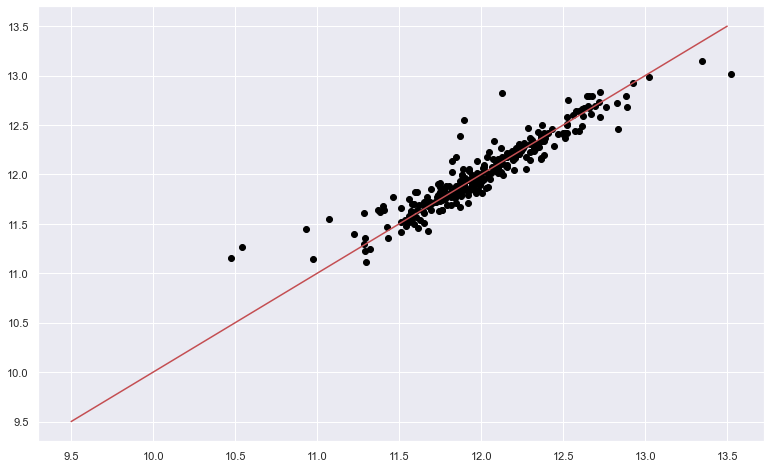

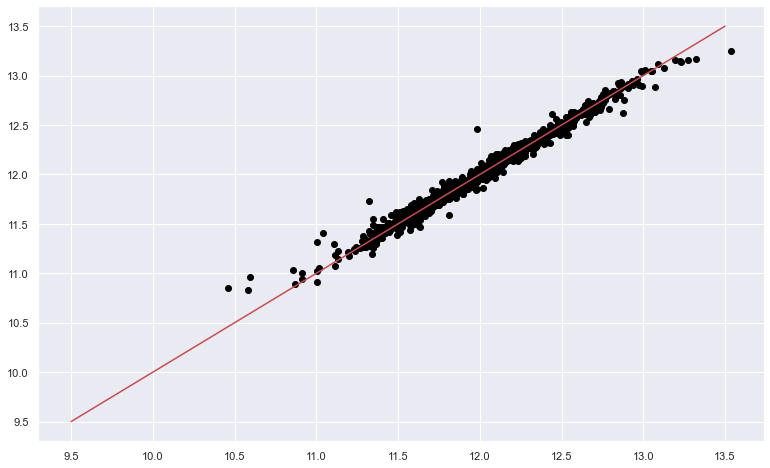

In [33]:
plt.figure(figsize=(13,8))
plt.scatter(y_test, lbg_model.predict(X_test), color='black')
plt.plot(np.linspace(9.5, 13.5, 2), np.linspace(9.5, 13.5, 2), c = 'r')

plt.figure(figsize=(13,8))
plt.scatter(y_train, lbg_model.predict(X_train), color='black')
plt.plot(np.linspace(9.5, 13.5, 2), np.linspace(9.5, 13.5, 2), c = 'r')

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

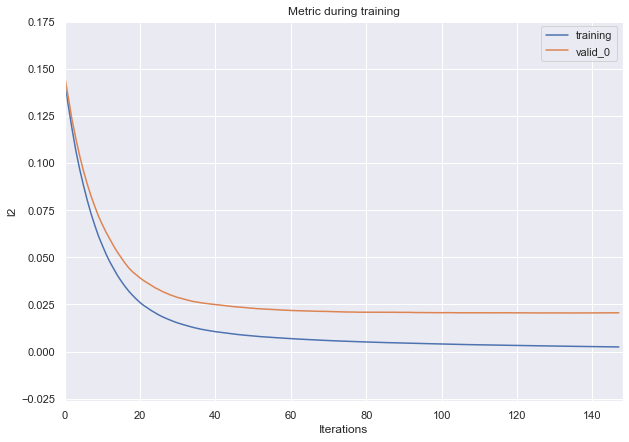

In [34]:
lgb.plot_metric(lbg_model, figsize  = (10,7))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

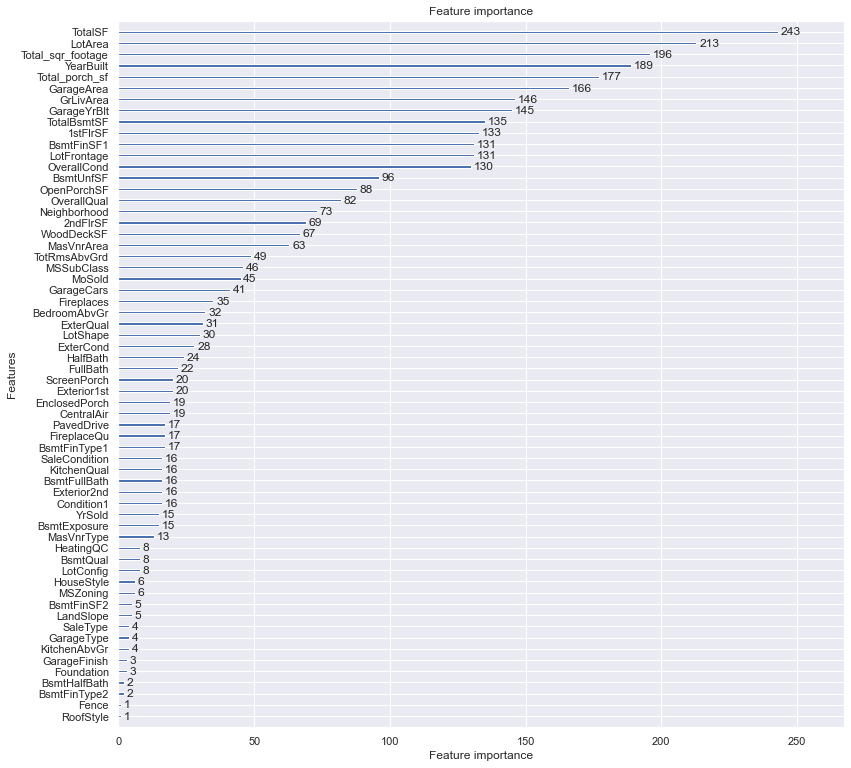

In [35]:
lgb.plot_importance(lbg_model, figsize  = (13,13))

In [57]:
fit_params = {
              #"early_stopping_rounds": 20,
              #"eval_set": [(X_test, y_test)],
              "eval_metric": 'rmse',
              'verbose': -1,
              'categorical_feature': cat_features,
              }
lbg_model = lgb.LGBMRegressor(random_state=random_state,
                              #boosting_type ='dart',
                              n_estimators=int(best['n_estimators']),
                              max_depth=int(best['max_depth']),
                              num_leaves = int(best['num_leaves']),
                              reg_alpha=best['reg_alpha'],
                              reg_lambda=best['reg_lambda'],
                              learning_rate=best['learning_rate'],
                              subsample=best['subsample'],
                              colsample_bytree=best['colsample_bytree'],
                              num_iterations = 200
                              )
lbg_model.fit(X, y, **fit_params)

evaluate(lbg_model, X, y)
#evaluate(lbg_model, X_test, y_test)

RMSLE: 0.04450076423757973


In [58]:
sub_predictions = lbg_model.predict(validation)
print("RMSLE submission: " + str(rmsle(sub_predictions, np.log1p(cheat["SalePrice"]))))
#evaluate(lbg_model, validation,  np.log1p(cheat["SalePrice"]))

RMSLE submission: 0.12510834942426025


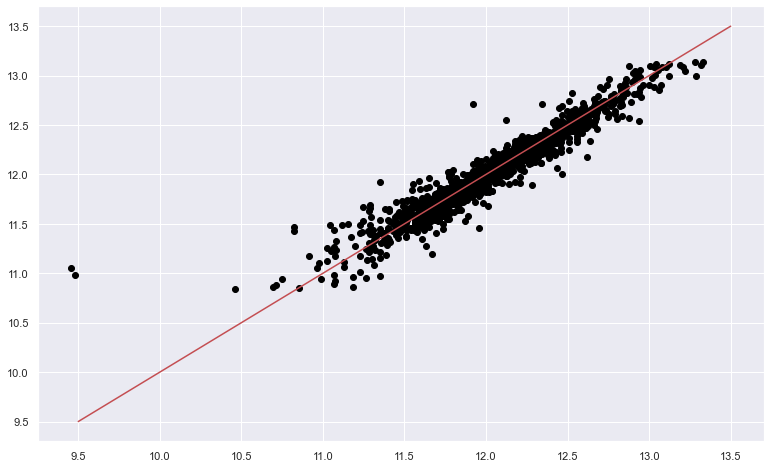

In [59]:
plt.figure(figsize=(13,8))
plt.scatter(np.log1p(cheat["SalePrice"]),sub_predictions, color='black')
plt.plot(np.linspace(9.5, 13.5, 2), np.linspace(9.5, 13.5, 2), c = 'r')

In [56]:
d = {'Id': val_ids.to_numpy(), 'SalePrice':  np.expm1(sub_predictions)}
df = pd.DataFrame(data=d)
df.to_csv('submission.csv', index=False)

df

,Id,SalePrice
0,1461,125396.202889
1,1462,163634.751263
2,1463,188419.750334
3,1464,196049.296039
4,1465,192362.297645
...,...,...
1454,2915,80482.526160
1455,2916,80109.404006
1456,2917,162519.933371
1457,2918,111892.279089
